In [74]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
from PIL import Image
from tqdm.auto import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
from torchvision.transforms import ToPILImage
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import re
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

## 파라미터 설정

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [52]:
CFG = {
    'IMG_SIZE':512,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'test_magnification':"20X",
    'pth' : "/data/pthfile/2023_06_07/train:20X_test:20X_epoch:50_(2023_06_07_03:24_PM).pth"
}

In [53]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
day = current_datetime.strftime("%Y_%m_%d")
hour = current_datetime.strftime("%I:%M_%p")
print(day, hour)

2023_06_13 01:26_PM


In [54]:
# server path
output_path = f"/data/output/{day}"
figure_path = f"{output_path}/figure"
test_data_path = f"/data/PDA_mask_img/test_mask/{CFG['test_magnification']}/**/*.png"


In [90]:
# server output name
pth_name = CFG['pth'].split('/')[4][:-4]
figure_name = f"{pth_name}_test:{CFG['test_magnification']}"

In [57]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [58]:
test_path_list = sorted(glob.glob(test_data_path))
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:5]

['/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=3108,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=3626,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=4144,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=4662,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10878,y=3626,w=518,h=518]-labelled.png']

In [59]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, transform = None):
        self.image = img_path
        self.mask = mask_path
        
        n_samples =  len(self.image)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.image = np.array(self.image)[idxs]
        self.mask = np.array(self.mask)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.image) # 데이터셋 길이
    
    def __getitem__(self, i):
        image = np.array(Image.open(self.image[i]))
        mask = np.array(Image.open(self.mask[i]))
        data = self.transform(image = image, mask = mask)
        image = data["image"]
        mask = data["mask"]
        return image, mask

## 데이터 불러오기

In [60]:
test_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2(transpose_mask=True)
])

In [61]:
# 테스트 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path= test_mask_path,
                         transform = test_transform)

In [62]:
test_loader = DataLoader(test_set, batch_size = CFG["BATCH_SIZE"])

In [63]:
print(f"test_data : {len(test_set)}")

test_data : 81


## Test

In [64]:
# Modeling
class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResUNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

In [65]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [66]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [67]:
# 평균값 계산
class AverageMeter: 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [68]:
# 학습 파라미터
model = ResUNet(num_classes=1).to(device)
model = nn.DataParallel(model)
criterion = DiceLoss().to(device)
loss_meter = AverageMeter()
score_meter = AverageMeter()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
model.load_state_dict(torch.load(CFG['pth'], map_location=device))

<All keys matched successfully>

In [70]:
def Test(model, criterion, test_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(test_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())
    
        test_loss_mean = loss_meter.avg
        test_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    
    return test_loss_mean, test_score_mean

In [71]:
test_loss, test_score = Test(model, criterion, test_loader, device)
result_df = pd.DataFrame({"Test Loss":[f"Test Loss: {test_loss}"],"Test Score":[f"Test Score: {test_score}"]}, index = ["Test"])
print(f"test_loss: {test_loss}, test_score: {test_score}")

  0%|          | 0/2 [00:00<?, ?it/s]

test_loss: 0.21434977650642395, test_score: 0.7856583893299103


In [72]:
def denormalize(tensor, mean=CFG["MEAN"], std=CFG["STD"]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

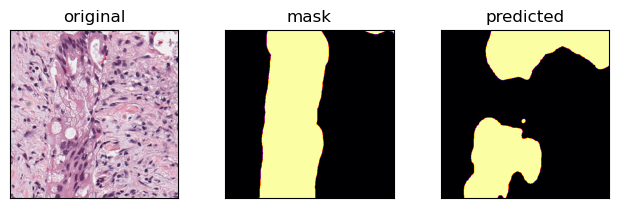

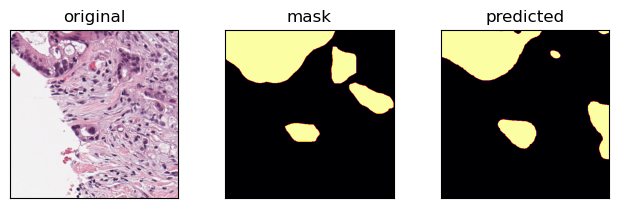

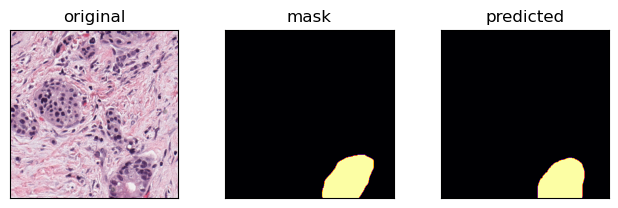

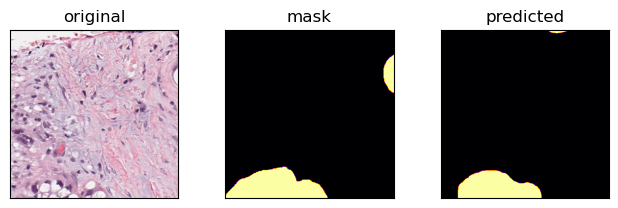

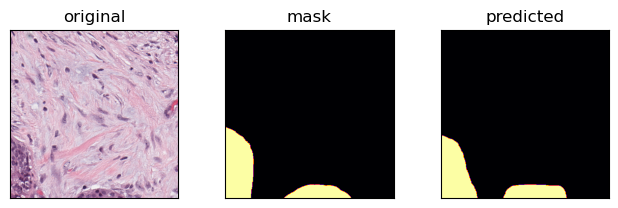

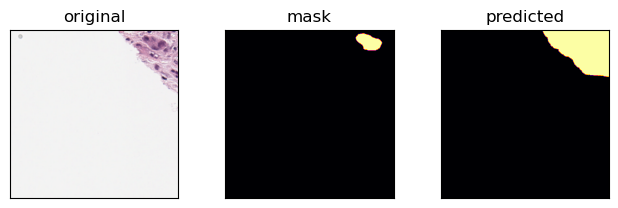

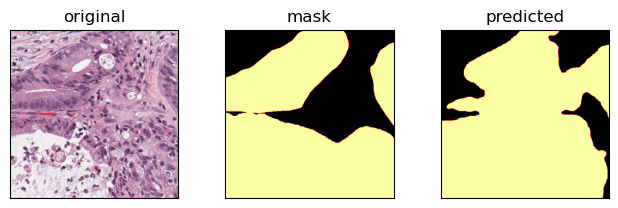

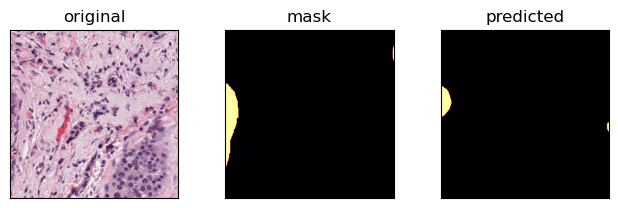

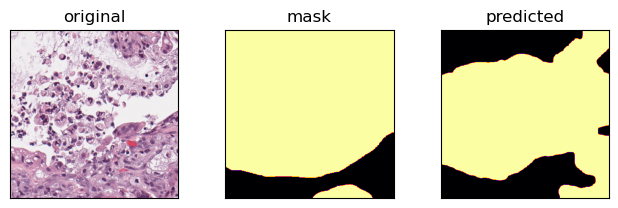

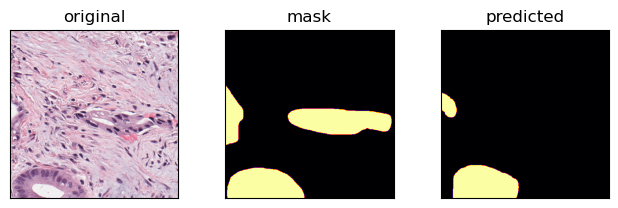

In [89]:
# output_save
mpl.rcParams['image.cmap'] = 'inferno'
os.makedirs(figure_path, exist_ok=True)

for i in range(10):
    
    data, label = test_set[i]
    label = torch.squeeze(label)

    with torch.no_grad():
        out = model(torch.unsqueeze(data, dim=0).to(device))
    out = torch.squeeze(out).sigmoid().to('cpu')
    pred = torch.ge(out, 0.5).float().to('cpu')

    # 오리지널 이미지
    plt.subplot(1,3,1)
    plt.title("original")
    plt.imshow(ToPILImage()(denormalize(data)))
    plt.xticks([]); plt.yticks([])

    # 마스크 이미지
    plt.subplot(1,3,2)
    plt.title("mask")
    plt.imshow(label)
    plt.xticks([]); plt.yticks([])
    
    # 마스크 예측 이미지
    plt.subplot(1,3,3)
    plt.title("predicted")
    plt.tight_layout()
    plt.imshow(pred)
    plt.xticks([]); plt.yticks([])

    plt.savefig(f'{figure_path}/{figure_name}_{i+1}.png', bbox_inches = 'tight')
    plt.show()

In [26]:
'''
for i in range(len(test_set)):
    
    data, label = test_set[i]
    label = torch.squeeze(label)

    with torch.no_grad():
        out = model(torch.unsqueeze(data, dim=0).to(device))
    out = torch.squeeze(out).sigmoid().to('cpu')
    pred = torch.ge(out, 0.5).float().to('cpu')
    pred_array = pred.numpy() * 255
    pred_array = pred_array.astype(np.uint8)
    coordinates = re.search(r'x=(\d+),y=(\d+)', test_set.mask[i])
    cv2.imwrite(f'data/output/pred/{coordinates[0]}.png',pred_array)
'''